# Step 1: Perform mapping between User Competency Level definitions to INCOSE Proficiency Levels

In [118]:
import os
import psycopg2
import json
from pydantic import BaseModel, Field
from langchain_openai import AzureChatOpenAI
from langchain.schema import HumanMessage
from typing import List
import time

In [ ]:
# Define a model for each INCOSE mapping
class INCOSEMapping(BaseModel):
    indicator: str = Field(
        description="The INCOSE indicator text or none."
    )
    incose_level: str = Field(
        description="The corresponding level from the INCOSE framework or none."
    )

# Define the overall mapping result model.
class MappingResult(BaseModel):
    """Mapping result between a user-defined competency indicator and the corresponding INCOSE framework indicator."""
    competency_id: int = Field(
        description="The unique identifier of the competency from the user-defined table."
    )
    competency_name: str = Field(
        description="The name of the competency as defined by the user."
    )
    user_level: str = Field(
        description="The competency level specified by the user (this value is not provided to the LLM)."
    )
    user_indicator: str = Field(
        description="The textual indicator provided by the user for the competency."
    )
    incose_mappings: List[INCOSEMapping] = Field(
        description="A list (maximum of two) of the most semantically similar INCOSE framework indicators along with their levels. If no mapping exists, this field should be set to ['none']."
    )

# Initialize the LangChain LLM using Azure OpenAI parameters.
import os

llm = AzureChatOpenAI(
    model="gpt-4o-mini",
    openai_api_key=os.environ.get("AZURE_API_KEY"),
    azure_endpoint=os.environ.get("AZURE_ENDPOINT"),
    api_version="2024-02-15-preview",
    temperature=0.5
)

In [147]:
structured_llm = llm.with_structured_output(MappingResult)

In [148]:
# Connect to the PostgreSQL database using the DATABASE_URL environment variable.
conn = psycopg2.connect(os.environ["DATABASE_URL"])
cur = conn.cursor()

# File to store results; each processed row will be appended as a JSON line.
RESULT_FILE = "results__3_05.jsonl"
''
# Main query to fetch user-defined competency indicators.
main_query = """
SELECT ci.competency_id, c.competency_name, ci.level, ci.indicator_en
FROM competency_indicators ci
JOIN competency c ON ci.competency_id = c.id
WHERE ci.competency_id NOT IN (5, 18, 9)
ORDER BY ci.competency_id, ci.level;
"""
cur.execute(main_query)
rows = cur.fetchall()

In [ ]:

for row in rows:
    competency_id, competency_name, level, indicator_en = row

    # Determine the appropriate backup mapping based on the user-defined level.
    if level.lower() == "kennen":
        backup_query = """
            SELECT indicator, level FROM competency_indicators_backup01112024
            WHERE competency_id = %s AND level IN (%s, %s, %s, %s, %s);
        """
        backup_params = (competency_id, "Awareness", "Supervised Practitioner", "Practitioner","Lead Practitioner", "Expert")
    elif level.lower() == "verstehen":
        backup_query = """
            SELECT indicator, level FROM competency_indicators_backup01112024
            WHERE competency_id = %s AND level IN (%s, %s, %s, %s, %s);
        """
        backup_params = (competency_id, "Awareness", "Supervised Practitioner", "Practitioner","Lead Practitioner", "Expert")
    elif level.lower() == "anwenden":
        backup_query = """
            SELECT indicator, level FROM competency_indicators_backup01112024
            WHERE competency_id = %s AND level IN (%s, %s, %s, %s, %s);
        """
        backup_params = (competency_id, "Awareness", "Supervised Practitioner", "Practitioner","Lead Practitioner", "Expert")
    elif level.lower() == "beherrschen":
        backup_query = """
            SELECT indicator, level FROM competency_indicators_backup01112024
            WHERE competency_id = %s AND level IN (%s, %s, %s, %s, %s);
        """
        # Here we include three values for consistency, though you may adjust as needed.
        backup_params = (competency_id, "Awareness", "Supervised Practitioner", "Practitioner","Lead Practitioner", "Expert")
    else:
        print(f"Skipping unknown level: {level} for competency_id {competency_id}")
        continue

    cur.execute(backup_query, backup_params)
    backup_rows = cur.fetchall()
    print(backup_rows)
    # Build a string with both indicator and incose level.
    if backup_rows:
        # For each row, format as "Indicator (Level: X)"
        backup_results_str = "\n".join([f"{r[0]} (Level: {r[1]})" for r in backup_rows])
    else:
        backup_results_str = "No backup indicators found"

    # Construct the prompt for mapping.
    # Note: We remove the "Level: {level}" line so the user-defined level isn't given to the LLM.
    prompt_text = f"""
        This is a competency indicator defined by the user:
        Competency ID: {competency_id}
        Competency Name: {competency_name}
        User Defined Indicator: {indicator_en}

        Below are the competency indicators from the INCOSE Systems Engineering framework:
        {backup_results_str}

        Map the user-defined indicator to the most semantically similar INCOSE indicator(s). For each match, return both the indicator and its corresponding INCOSE level. You may return one or two matches if available; if you find only one match, that is sufficient. If no indicators are sufficiently similar, respond with "none".
        Ensure that you only return maximum of two matching INCOSE indicators that best matches the user defined indicator semantically.
        """

    #print(prompt_text)
    try:
        print(f"Calling LLM for competency_id {competency_id}")
        mapping_result = structured_llm.invoke(prompt_text)
    except Exception as e:
        print(f"Error processing competency_id {competency_id}: {e}")
        continue

    # Update the mapping result with the fields not provided to the LLM (like user_level and user_indicator).
    mapping_result = mapping_result.copy(update={
        "competency_id": competency_id,
        "competency_name": competency_name,
        "user_level": level,
        "user_indicator": indicator_en
    })

    # Append the mapping result to the result file.
    with open(RESULT_FILE, "a") as f:
        f.write(json.dumps(mapping_result.dict()) + "\n")
    
    print(f"Processed competency_id {competency_id}")
    # Wait for 10 seconds before making the next API call.
    time.sleep(10)

cur.close()
conn.close()

  

# Step 2: Analyze the results

### Analysis on LLM mappings between Konemann et al Levels to INCOSE Levels

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
RESULT_FILE = "results__3_05.jsonl"

# Prepare a list of records for building a DataFrame.
data = []

with open(RESULT_FILE, "r") as f:
    for line in f:
        record = json.loads(line)
        competency_id = record.get("competency_id", None)
        user_level = record.get("user_level", "unknown")
        mappings = record.get("incose_mappings", [])
        
        # If no mappings or a "none" mapping is returned.
        if not mappings or (len(mappings) == 1 and isinstance(mappings[0], str) and mappings[0].lower() == "none"):
            data.append({
                "competency_id": competency_id,
                "user_level": user_level,
                "incose_level": "none"
            })
        else:
            # For each mapping, extract the INCOSE level.
            for mapping in mappings:
                if isinstance(mapping, dict):
                    incose_level = mapping.get("incose_level", "unknown")
                else:
                    incose_level = str(mapping)
                data.append({
                    "competency_id": competency_id,
                    "user_level": user_level,
                    "incose_level": incose_level
                })


Raw Data with competency_id for cross verification:
     competency_id   user_level             incose_level
0                1     anwenden             Practitioner
1                1     anwenden             Practitioner
2                1  beherrschen             Practitioner
3                1  beherrschen  Supervised Practitioner
4                1       kennen                Awareness
..             ...          ...                      ...
131             17  beherrschen             Practitioner
132             17       kennen                Awareness
133             17       kennen                Awareness
134             17    verstehen                Awareness
135             17    verstehen  Supervised Practitioner

[136 rows x 3 columns]

Pivot Table:
incose_level  Awareness  Expert  Lead Practitioner  Practitioner  \
user_level                                                         
anwenden              4       1                  1            12   
beherrschen           

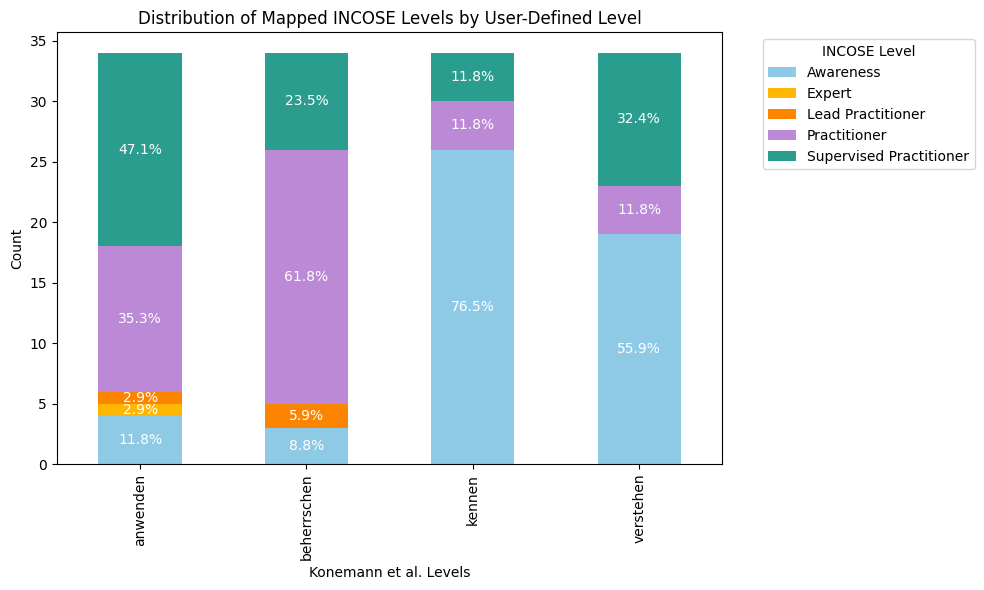

In [12]:
# Create a DataFrame including competency_id for cross verification.
df = pd.DataFrame(data)
print("Raw Data with competency_id for cross verification:")
print(df)

# Create a pivot table where rows are user levels and columns are INCOSE levels.
pivot = df.groupby(["user_level", "incose_level"]).size().unstack(fill_value=0)
print("\nPivot Table:")
print(pivot)

# Define a custom color palette (adjust the colors to your preference)
custom_colors = ["#8ecae6", "#ffb703", "#fb8500", "#bc89d6", "#2a9d8f"]  # Lighter violet (#bc89d6)

# Plot the stacked bar chart with custom colors
fig, ax = plt.subplots(figsize=(10, 6))
pivot.plot(kind='bar', stacked=True, ax=ax, color=custom_colors)

ax.set_title("Distribution of Mapped INCOSE Levels by User-Defined Level")
ax.set_xlabel("Konemann et al. Levels")
ax.set_ylabel("Count")
ax.legend(title="INCOSE Level", bbox_to_anchor=(1.05, 1), loc='upper left')

# Calculate totals per user level for percentage annotations
totals = pivot.sum(axis=1)

# Annotate each segment with its percentage relative to the bar total
for i, user_level in enumerate(pivot.index):
    cumulative = 0
    for col in pivot.columns:
        count = pivot.loc[user_level, col]
        if count > 0:
            percentage = count / totals[user_level] * 100
            ax.text(i, cumulative + count/2, f'{percentage:.1f}%', 
                    ha='center', va='center', color='white', fontsize=10)
        cumulative += count

plt.tight_layout()
plt.show()


## Sankey Diagram

In [160]:
import json
import pandas as pd
import plotly.graph_objects as go

RESULT_FILE = "results__3.jsonl"

# Step 1: Read the JSONL file into a list of dictionaries.
data = []
with open(RESULT_FILE, "r") as f:
    for line in f:
        record = json.loads(line)
        competency_id = record.get("competency_id", None)
        user_level = record.get("user_level", "unknown")
        mappings = record.get("incose_mappings", [])
        
        if not mappings or (len(mappings) == 1 and isinstance(mappings[0], str) and mappings[0].lower() == "none"):
            data.append({
                "competency_id": competency_id,
                "user_level": user_level,
                "incose_level": "none"
            })
        else:
            for mapping in mappings:
                if isinstance(mapping, dict):
                    incose_level = mapping.get("incose_level", "unknown")
                else:
                    incose_level = str(mapping)
                data.append({
                    "competency_id": competency_id,
                    "user_level": user_level,
                    "incose_level": incose_level
                })

df = pd.DataFrame(data)
print("Raw Data:")
print(df.head())

# Step 2: Group data by user_level and incose_level to get counts.
grouped = df.groupby(["user_level", "incose_level"]).size().reset_index(name="count")

# Step 3: Define unique user levels and INCOSE levels
user_levels = list(df["user_level"].unique())
incose_levels = list(df["incose_level"].unique())

# If "none" is in user_levels, remove it and ensure it's in incose_levels
if "none" in user_levels:
    user_levels.remove("none")
if "none" not in incose_levels:
    incose_levels.append("none")

# Our final labels = user_levels (left) + incose_levels (right)
labels = user_levels + incose_levels

# Build dictionaries to map each label to an index
label_to_idx = {label: i for i, label in enumerate(labels)}

# Step 4: Assign distinct colors for user levels vs. INCOSE levels
user_level_colors = {
    "kennen": "rgba(166, 206, 227, 0.8)",
    "verstehen": "rgba(31, 120, 180, 0.8)",
    "anwenden": "rgba(178, 223, 138, 0.8)",
    "beherrschen": "rgba(51, 160, 44, 0.8)",
    "unknown": "rgba(150, 150, 150, 0.8)"
}
incose_level_colors = {
    "Awareness": "rgba(251, 154, 153, 0.8)",
    "Supervised Practitioner": "rgba(227, 26, 28, 0.8)",
    "Practitioner": "rgba(253, 191, 111, 0.8)",
    "Lead Practitioner": "rgba(255, 127, 0, 0.8)",
    "Expert": "rgba(202, 178, 214, 0.8)",
    "none": "rgba(200, 200, 200, 0.8)",
    "unknown": "rgba(180, 180, 180, 0.8)"
}

# Create a color list for each node in the 'labels' list
node_colors = []
for lbl in labels:
    if lbl in user_level_colors:
        node_colors.append(user_level_colors[lbl])
    elif lbl in incose_level_colors:
        node_colors.append(incose_level_colors[lbl])
    else:
        node_colors.append("rgba(100, 100, 100, 0.8)")  # fallback color

# Step 5: Build source, target, value arrays, and link labels
sources = []
targets = []
values = []
link_labels = []
link_colors = []

for _, row in grouped.iterrows():
    ul = row["user_level"]
    il = row["incose_level"]
    count = row["count"]
    
    if ul not in label_to_idx or il not in label_to_idx:
        continue
    
    source_idx = label_to_idx[ul]
    target_idx = label_to_idx[il]
    
    sources.append(source_idx)
    targets.append(target_idx)
    values.append(count)
    
    # The link label will show the count
    link_labels.append(f"Count: {count}")
    
    # The link color matches the user level color
    link_color = user_level_colors.get(ul, "rgba(100, 100, 100, 0.5)")
    link_colors.append(link_color)

# Step 6: Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=link_colors,
        label=link_labels,
        # The hovertemplate includes the link's label (count) and the node names
        customdata=link_labels,
        hovertemplate=(
            'User Level: %{source.label}<br>'
            'INCOSE Level: %{target.label}<br>'
            'Count: %{value}<extra></extra>'
        )
    )
)])

fig.update_layout(
    title_text="Sankey Diagram: User-Defined Competency Levels to INCOSE Mappings",
    font_size=10
)

fig.show()


Raw Data:
   competency_id   user_level  incose_level
0              1     anwenden  Practitioner
1              1     anwenden  Practitioner
2              1  beherrschen  Practitioner
3              1  beherrschen  Practitioner
4              1       kennen     Awareness


# Statistical Test

In [162]:
import json
import random
import numpy as np
import psycopg2
import time
from scipy.stats import ttest_ind
from langchain_openai import AzureOpenAIEmbeddings

In [ ]:
# Configuration variables (ensure these are set in your environment or code)
api_key = os.environ.get("AZURE_API_KEY")
api_base = os.environ.get("AZURE_API_BASE")
api_version = "2024-02-01"
azure_embedding_deployment_name = "text-embedding-ada-002"

In [164]:
# Initialize the Azure OpenAI Embeddings instance.
azure_embeddings = AzureOpenAIEmbeddings(
    api_key=api_key,
    azure_endpoint=api_base,
    openai_api_version=api_version,
    model=azure_embedding_deployment_name
)

# Function to compute cosine similarity
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [165]:
# Load results from the JSONL file.
RESULT_FILE = "results__3.jsonl"
results = []
with open(RESULT_FILE, "r") as f:
    for line in f:
        results.append(json.loads(line))

# Lists to store similarity scores.
correct_sims = []
random_sims = []

# Connect to the PostgreSQL database.
conn = psycopg2.connect(os.environ["DATABASE_URL"])
cur = conn.cursor()

In [166]:
# --- Process each record ---
for record in results:
    user_indicator = record["user_indicator"]
    # Compute embedding for the user-defined indicator.
    user_emb = azure_embeddings.embed_query(user_indicator)
    
    mappings = record.get("incose_mappings", [])
    
    # For each correct mapping in the record, compute similarity and sample a random similarity.
    if mappings and not (len(mappings) == 1 and isinstance(mappings[0], str) and mappings[0].lower() == "none"):
        for mapping in mappings:
            # Extract the indicator text from the mapping.
            if isinstance(mapping, dict):
                mapping_indicator = mapping.get("indicator", "")
            else:
                mapping_indicator = str(mapping)
            if mapping_indicator:
                # Compute the embedding and similarity for the correct mapping.
                mapping_emb = azure_embeddings.embed_query(mapping_indicator)
                sim_correct = cosine_similarity(np.array(user_emb), np.array(mapping_emb))
                correct_sims.append(sim_correct)
                
                # --- Random Mapping ---
                # Sample a random row number between 1 and 757.
                random_row_num = random.randint(1, 757)
                random_query = f"""
                SELECT indicator FROM (
                    SELECT indicator, row_number() OVER () AS row_num 
                    FROM competency_indicators_backup01112024
                ) sub
                WHERE row_num = {random_row_num}
                """
                cur.execute(random_query)
                random_result = cur.fetchone()
                if random_result:
                    random_indicator = random_result[0]
                    random_emb = azure_embeddings.embed_query(random_indicator)
                    sim_random = cosine_similarity(np.array(user_emb), np.array(random_emb))
                    random_sims.append(sim_random)
                # Wait 10 seconds between API calls to avoid rate or token limits.
                time.sleep(5)
    else:
        # If there are no correct mappings (i.e., a "none" result), skip.
        continue

cur.close()
conn.close()

In [167]:
# --- Statistical Analysis ---
# Perform a t-test comparing correct similarity scores and random similarity scores.
t_stat, p_val = ttest_ind(correct_sims, random_sims, equal_var=False)

print("T-test results:")
print(f"t-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")
print(f"Average similarity (correct mappings): {np.mean(correct_sims):.3f}")
print(f"Average similarity (random mappings): {np.mean(random_sims):.3f}")

T-test results:
t-statistic: 16.177, p-value: 0.000
Average similarity (correct mappings): 0.827
Average similarity (random mappings): 0.779


## Restricting the sample

In [168]:
# --- Load mapping results from the JSONL file ---
RESULT_FILE = "results__3.jsonl"
results = []
with open(RESULT_FILE, "r") as f:
    for line in f:
        results.append(json.loads(line))

# Lists to store similarity scores.
correct_sims = []
random_sims = []

# --- Connect to the PostgreSQL database ---
conn = psycopg2.connect(os.environ["DATABASE_URL"])
cur = conn.cursor()

# --- Process each record ---
for record in results:
    user_indicator = record["user_indicator"]
    # Compute embedding for the user-defined indicator.
    user_emb = azure_embeddings.embed_query(user_indicator)
    
    mappings = record.get("incose_mappings", [])
    
    # For each correct mapping, compute similarity and sample a random similarity.
    if mappings and not (len(mappings) == 1 and isinstance(mappings[0], str) and mappings[0].lower() == "none"):
        for mapping in mappings:
            if isinstance(mapping, dict):
                mapping_indicator = mapping.get("indicator", "")
            else:
                mapping_indicator = str(mapping)
            if mapping_indicator:
                # Compute embedding and cosine similarity for the correct mapping.
                mapping_emb = azure_embeddings.embed_query(mapping_indicator)
                sim_correct = cosine_similarity(np.array(user_emb), np.array(mapping_emb))
                correct_sims.append(sim_correct)
                
                # --- Random Mapping for the SAME competency ---
                # Use the competency_id from the record to restrict the random query.
                competency_id = record.get("competency_id")
                random_query = f"""
                SELECT indicator 
                FROM competency_indicators_backup01112024
                WHERE competency_id = {competency_id}
                ORDER BY random()
                LIMIT 1;
                """
                cur.execute(random_query)
                random_result = cur.fetchone()
                if random_result:
                    random_indicator = random_result[0]
                    random_emb = azure_embeddings.embed_query(random_indicator)
                    sim_random = cosine_similarity(np.array(user_emb), np.array(random_emb))
                    random_sims.append(sim_random)
                # Wait 10 seconds between API calls.
                time.sleep(5)
    else:
        continue

cur.close()
conn.close()



In [169]:
# --- Statistical Analysis ---
t_stat, p_val = ttest_ind(correct_sims, random_sims, equal_var=False)

print("T-test results:")
print(f"t-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")
print(f"Average similarity (correct mappings): {np.mean(correct_sims):.3f}")
print(f"Average similarity (random mappings): {np.mean(random_sims):.3f}")

T-test results:
t-statistic: 5.138, p-value: 0.000
Average similarity (correct mappings): 0.827
Average similarity (random mappings): 0.811


In [171]:
p_val

5.339373244550964e-07